In [63]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from matplotlib.patches import FancyBboxPatch, BoxStyle

def explicit_homozygous(genotype):
    # requires genotype to be a list of lists, with 1 or 2 elements each.
    return [chromosome*2 if len(chromosome)==1 else chromosome for chromosome in genotype]

def simplify_homozygous(genotype):
    return [[chromosome[0]] if chromosome[0]==chromosome[1] else chromosome for chromosome in genotype]

def str_to_chromosomes(genotype_str):
    # string genotype with ;; notation into chromosomes list
    # also will add + for wildtype, assume chr2 if not written, and duplicate allele if only one is written
    genotype = [chr.strip() for chr in genotype_str.split(';')]
    if len(genotype) < 3:
        genotype = ['+/+'] + genotype
    genotype = ['+/+' if chromosome == '' else chromosome for chromosome in genotype]
    genotype = [chromosome.split('/') for chromosome in genotype]
    genotype = explicit_homozygous(genotype)
    return genotype

def chromosomes_to_string(chromosome_list):
    return ' ; '.join(['/'.join(chromosome) for chromosome in chromosome_list])

def fix_genotype_notation(genotype):
    return chromosomes_to_string(str_to_chromosomes(genotype))

def get_unique_progeny_chromosome_pool(fly1, fly2):
    progeny_chromosome_pool_list = []
    for ichr in range(3):
        all_sorted_alleles = [tuple(sorted(x)) for x in itertools.product(fly1[ichr],fly2[ichr])]
        all_setted_alleles = [list(x) for x in set(all_sorted_alleles)]
        progeny_chromosome_pool_list.append(all_setted_alleles)
    return progeny_chromosome_pool_list

def clean_lethals_from_pool(progeny_chromosome_pool, balancers_table):
    return [[alleles for alleles in chromosome_list if not ((alleles[0]==alleles[1]) and (alleles[0] in balancers_table.label.tolist()))] for chromosome_list in progeny_chromosome_pool]
        
def get_progeny(fly1,fly2,balancers_table=None):

    if type(fly1) == str:
        fly1=str_to_chromosomes(fly1)
    if type(fly2) == str:
        fly2=str_to_chromosomes(fly2)

    progeny_chromosome_pool = get_unique_progeny_chromosome_pool(fly1, fly2)
    progeny_chromosome_pool = clean_lethals_from_pool(progeny_chromosome_pool, balancers_table)

    # get all possible products of cross, ignore duplicates (but not considering change of order)
    # possible_chromosomes = [set([sorted(x) for x in itertools.product(fly1[ichr],fly2[ichr])]) for ichr in range(3)]
    # print(possible_chromosomes)
    # possible_chromosomes = [[alleles for alleles in chromosome_list if not ((alleles[0]==alleles[1]) and (alleles[0] in balancers_table.label.tolist()))] for chromosome_list in possible_chromosomes]
    # print(possible_chromosomes)
    possible_progeny = [z for z in itertools.product(*progeny_chromosome_pool)]
    progeny_genotypes = [chromosomes_to_string(chromosome_list) for chromosome_list in possible_progeny]
    return progeny_genotypes

In [58]:
# set goal genotype, and fix notation
goal_genotype = '+/+ ; UAS<stop>Kir2.1/UAS<stop>Kir2.1 ; VT40556-Gal4, fru-FLP/VT40556-Gal4, fru-FLP'
goal_genotype = fix_genotype_notation(goal_genotype)
goal_genotype

'+/+ ; UAS<stop>Kir2.1/UAS<stop>Kir2.1 ; VT40556-Gal4, fru-FLP/VT40556-Gal4, fru-FLP'

In [59]:
# load stock and balancers tables, and fix notation
fly_stock_table = pd.read_excel('simple_crosses_table.xlsx')
balancers_table = pd.read_excel('balancers_table.xlsx')
for gen in fly_stock_table.genotype:
    fly_stock_table.loc[fly_stock_table.genotype == gen,'genotype'] = fix_genotype_notation(gen)
fly_stock_table['split_genotype'] = [str_to_chromosomes(genotype) for genotype in fly_stock_table.genotype]
fly_stock_table

,ID,description,genotype,split_genotype
0,B#67686,UAS > stop > Kir2.1 on chr2,w[*]/w[*] ; UAS<stop>Kir2.1/CyO ; +/+,"[[w[*], w[*]], [UAS<stop>Kir2.1, CyO], [+, +]]"
1,S#272,"Chrimson pIP10 from Philipsborn 2011, VT40556-...","+/+ ; UAS<stop>Chrimson,mVenus/CyO ; VT40556-G...","[[+, +], [UAS<stop>Chrimson,mVenus, CyO], [VT4..."
2,balancers,NaN,+/+ ; s/CyO ; Tm2/Tm6b,"[[+, +], [s, CyO], [Tm2, Tm6b]]"


In [52]:

fly1 = fly_stock_table.genotype[0]
fly2 = fly_stock_table.genotype[0]
fly1=str_to_chromosomes(fly1)
fly2=str_to_chromosomes(fly2)
        
progeny_chromosome_pool = get_unique_progeny_chromosome_pool(fly1, fly2)
progeny_chromosome_pool = clean_lethals_from_pool(progeny_chromosome_pool, balancers_table)

print(progeny_chromosome_pool)


[[['w[*]', 'w[*]']], [['CyO', 'UAS<stop>Kir2.1'], ['UAS<stop>Kir2.1', 'UAS<stop>Kir2.1']], [['+', '+']]]


In [66]:
# for fly1, fly2 in itertools.product(fly_stock_table.genotype,fly_stock_table.genotype):

fly1 = fly_stock_table.genotype[0]
fly2 = fly_stock_table.genotype[0]

print('fly 1:\n',fly1)
print('fly 2:\n',fly2)

print('progeny:')
progeny_genotypes = get_progeny(fly1=fly1,fly2=fly2,balancers_table=balancers_table)
print(progeny_genotypes)

fly1_chromosomes = str_to_chromosomes(fly1)
fly2_chromosomes = str_to_chromosomes(fly2)

found_balancers = [z for z in set([x for chromosomes in [fly1_chromosomes,fly2_chromosomes] for chr in chromosomes for x in chr]) if z in balancers_table.label.tolist()]
print('found balancers:\n',found_balancers)

fly 1:
 w[*]/w[*] ; UAS<stop>Kir2.1/CyO ; +/+
fly 2:
 w[*]/w[*] ; UAS<stop>Kir2.1/CyO ; +/+
progeny:
['w[*]/w[*] ; CyO/UAS<stop>Kir2.1 ; +/+', 'w[*]/w[*] ; UAS<stop>Kir2.1/UAS<stop>Kir2.1 ; +/+']


In [6]:
fly1 = str_to_chromosomes(fly_stock_table.genotype[0])
fly2 = str_to_chromosomes(fly_stock_table.genotype[0])
[set([tuple(set(x)) for x in itertools.product(fly1[ichr],fly2[ichr])]) for ichr in range(3)]

[{('w[*]',)},
 {('CyO',), ('UAS<stop>Kir2.1',), ('UAS<stop>Kir2.1', 'CyO')},
 {('+',)}]

In [7]:
ichr = 1
set([tuple([y for y in set(x)]) for x in itertools.product(fly1[ichr],fly2[ichr])])

{('CyO',), ('UAS<stop>Kir2.1',), ('UAS<stop>Kir2.1', 'CyO')}

In [8]:
possible_chromosomes = [set([tuple(set(x)) for x in itertools.product(fly1[ichr],fly2[ichr])]) for ichr in range(3)]
print(possible_chromosomes)
possible_chromosomes = [(chromosome[0],chromosome[0]) if len(chromosome)==1 else tuple(chromosome) for chromosome in possible_chromosomes]
print(possible_chromosomes)
possible_chromosomes = [[alleles for alleles in chromosome_list if not ((alleles[0]==alleles[1]) and (alleles[0] in balancers_table.label.tolist()))] for chromosome_list in possible_chromosomes]
print(possible_chromosomes)
possible_progeny = [z for z in itertools.product(*possible_chromosomes)]
print(possible_progeny)
progeny_genotypes = [chromosomes_to_string(chromosome_list) for chromosome_list in possible_progeny]
    

[{('w[*]',)}, {('CyO',), ('UAS<stop>Kir2.1', 'CyO'), ('UAS<stop>Kir2.1',)}, {('+',)}]


TypeError: 'set' object is not subscriptable

In [36]:
progeny_sets = set()
for prog in progeny_genotypes:
    prog_chrms_sets = [set(x) for x in str_to_chromosomes(prog)]
    print(prog_chrms_sets)
    progeny_sets.add(prog_chrms_sets)
print(progeny_sets)
# progeny_sets = set(progeny_sets)
# progeny_sets


[{'w[*]'}, {'UAS<stop>Kir2.1'}, {'+'}]


TypeError: unhashable type: 'list'

In [6]:
set([x for chr in fly1_chromosomes for x in chr])

{'+', 'CyO', 'UAS<stop>Kir2.1', 'w[*]'}

In [7]:
balancers_table.label.tolist()

['Tm2', 'Tm6b', 'CyO', 's']

In [8]:
for fly1, fly2 in itertools.product(fly_stock_table.genotype,fly_stock_table.genotype):
    progeny_genotypes = get_progeny(fly1=str_to_chromosomes(fly1),fly2=str_to_chromosomes(fly2),balancers_table=balancers_table)

    


    if goal_genotype not in progeny_genotypes:
        second_step_stock = [fly1, fly2] + progeny_genotypes
        # for fly3, fly4 in itertools.product(second_step_stock,second_step_stock):
        #     second_progeny_genotypes = get_progeny(fly1=str_to_chromosomes(fly3),fly2=str_to_chromosomes(fly4),balancers_table=balancers_table)
    #         if goal_genotype in second_progeny_genotypes:
    #             print('viable cross plan')
    #             print(fly1,' x ', fly2)
    #             print(fly3,' x ', fly4)
    # else:
    #     print('viable cross plan')
    #     print(fly1,' x ', fly2)


# Working on the visualization

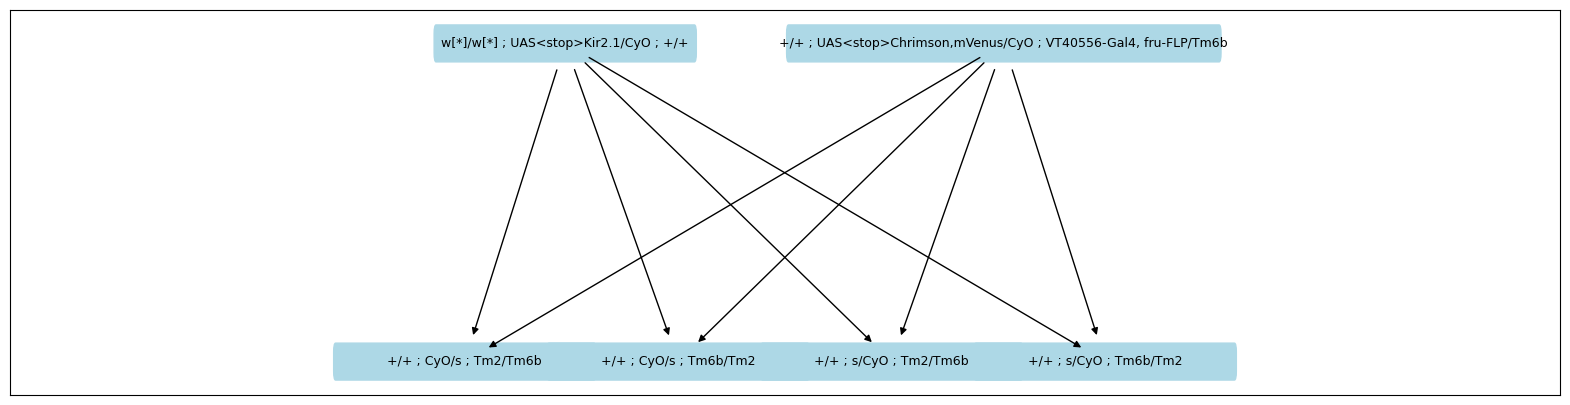

In [9]:
fig, ax = plt.subplots(figsize=[20,5])

# create graph
G = nx.DiGraph()
for gen,xscale_fly in zip(fly_stock_table.genotype,[3,1.8,4]):
    G.add_node(gen, xscale = xscale_fly)
for gen,xscale_fly in zip(progeny_genotypes,[3]*len(progeny_genotypes)):
    G.add_node(gen, xscale = xscale_fly)
for parent, progeny in itertools.product(fly_stock_table.genotype[[0,1]],progeny_genotypes):
    G.add_edge(parent,progeny)

# get positions for graph 
pos = graphviz_layout(G, prog="dot")
# plot graph
nx.draw_networkx_edges(G, pos=pos, ax=ax, min_source_margin=20, min_target_margin=20)

# scale of ax to draw rectangles and labels over
xscale = (ax.get_xlim()[1] - ax.get_xlim()[0])
yscale = (ax.get_ylim()[1] - ax.get_ylim()[0])

# plot rectangles and labels
for n in G.nodes:
    label_size_x = xscale/G.nodes[n]['xscale']
    label_size_y = yscale/20
    fancybox = FancyBboxPatch(np.asarray(pos[n]) - np.asarray((label_size_x/2,label_size_y/2)), label_size_x, label_size_y, color='lightblue', zorder=-5, boxstyle=BoxStyle("Round", pad=2))
    ax.add_patch(fancybox)
    ax.text(*pos[n],n,ha='center',va='center',fontsize=9)
plt.xlim([ax.get_xlim()[0]-0.5*xscale,ax.get_xlim()[1]+0.5*xscale])
plt.show()